In [3]:
import platform
import os
from psutil import virtual_memory
def print_colab_specs():
    # CPU Info
    cpu_info = os.popen('lscpu').readlines()
    cpu_model = [line for line in cpu_info if "Model name" in line]
    cpu_model = cpu_model[0].split(":")[1].strip() if cpu_model else "Unknown CPU Model"

    # GPU Info (if available)
    gpu_info = os.popen('nvidia-smi').read() if os.path.exists('/usr/bin/nvidia-smi') else 'No GPU available'

    # RAM Info
    ram_info = virtual_memory()

    # OS and Python Version Info
    os_info = platform.platform()
    python_version = platform.python_version()

    # Print the specs
    print("=== Operating System Information ===")
    print(f"Operating System: {os_info}")

    print("\n=== Python Version ===")
    print(f"Python Version: {python_version}")

    print("\n=== CPU Information ===")
    print(f"CPU Model: {cpu_model}")

    print("\n=== GPU Information ===")
    print(gpu_info)

    print("\n=== RAM Information ===")
    print(f"Total RAM: {ram_info.total / (1024**3):.2f} GB")

# Call the function to display the specs
print_colab_specs()


=== Operating System Information ===
Operating System: Linux-6.1.85+-x86_64-with-glibc2.35

=== Python Version ===
Python Version: 3.10.12

=== CPU Information ===
CPU Model: Intel(R) Xeon(R) CPU @ 2.30GHz

=== GPU Information ===
Sun Oct 13 10:35:31 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   56C    P8

In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
# from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score,f1_score, confusion_matrix, classification_report, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, GridSearchCV
import xgboost as xgb
from sklearn.feature_selection import SelectKBest, chi2
import joblib
from joblib import parallel_backend
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import time

In [2]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [3]:
dataset_path = '/content/drive/MyDrive/CT294/dataset/nearest-earth-objects(1910-2024).csv'
# dataset_path = '/content/drive/Shareddrives/CT294/dataset/nearest-earth-objects(1910-2024).csv'
# dataset_path = '/content/nearest-earth-objects(1910-2024).csv'

#Data preprocessing

In [4]:
df = pd.read_csv(dataset_path)
df.head(10)

,neo_id,name,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,orbiting_body,relative_velocity,miss_distance,is_hazardous
0,2162117,162117 (1998 SD15),19.14,0.394962,0.883161,Earth,71745.401048,5.814362e+07,False
1,2349507,349507 (2008 QY),18.50,0.530341,1.185878,Earth,109949.757148,5.580105e+07,True
2,2455415,455415 (2003 GA),21.45,0.136319,0.304818,Earth,24865.506798,6.720689e+07,False
3,3132126,(2002 PB),20.63,0.198863,0.444672,Earth,78890.076805,3.039644e+07,False
4,3557844,(2011 DW),22.70,0.076658,0.171412,Earth,56036.519484,6.311863e+07,False
5,3656926,(2014 BT8),25.00,0.026580,0.059435,Earth,47477.649832,4.290521e+07,False
6,3421513,(2008 OX1),21.50,0.133216,0.297879,Earth,57853.295346,2.727908e+07,True
7,3541504,(2010 OF101),19.75,0.298233,0.666868,Earth,46972.486794,6.997593e+07,False
8,3836942,(2018 YH),21.70,0.121494,0.271669,Earth,37424.548382,5.657727e+06,True
9,3892166,(2019 UP13),23.45,0.054269,0.121350,Earth,38524.867869,6.166118e+07,False


In [5]:
df.drop(['neo_id','name','orbiting_body'], axis=1, inplace=True)

In [6]:
df.head(10)

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,19.14,0.394962,0.883161,71745.401048,5.814362e+07,False
1,18.50,0.530341,1.185878,109949.757148,5.580105e+07,True
2,21.45,0.136319,0.304818,24865.506798,6.720689e+07,False
3,20.63,0.198863,0.444672,78890.076805,3.039644e+07,False
4,22.70,0.076658,0.171412,56036.519484,6.311863e+07,False
5,25.00,0.026580,0.059435,47477.649832,4.290521e+07,False
6,21.50,0.133216,0.297879,57853.295346,2.727908e+07,True
7,19.75,0.298233,0.666868,46972.486794,6.997593e+07,False
8,21.70,0.121494,0.271669,37424.548382,5.657727e+06,True
9,23.45,0.054269,0.121350,38524.867869,6.166118e+07,False


In [7]:
df.duplicated().sum()

5

In [8]:
df.drop_duplicates(inplace=True)

In [9]:
def fill_null_value(df):
  for col in df.columns:
      df[col].fillna(df[col].median(), inplace=True) #Điền giá trị bị thiếu bằng giá trị trung vị
  return df

In [11]:
df = fill_null_value(df)

<ipython-input-9-3c800618b110>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True) #Điền giá trị bị thiếu bằng giá trị trung vị
<ipython-input-9-3c800618b110>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[co

In [10]:
df.isnull().sum()

,0
absolute_magnitude,28
estimated_diameter_min,28
estimated_diameter_max,28
relative_velocity,0
miss_distance,0
is_hazardous,0


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 338194 entries, 0 to 338198
Data columns (total 6 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   absolute_magnitude      338194 non-null  float64
 1   estimated_diameter_min  338194 non-null  float64
 2   estimated_diameter_max  338194 non-null  float64
 3   relative_velocity       338194 non-null  float64
 4   miss_distance           338194 non-null  float64
 5   is_hazardous            338194 non-null  bool   
dtypes: bool(1), float64(5)
memory usage: 15.8 MB


Normalize


In [13]:
def linear_nomalize(col):
  min = col.min()
  max = col.max()
  return (col - min) / (max - min)

numeric_col = ['absolute_magnitude', 'relative_velocity', 'miss_distance']

for col in numeric_col:
  df[col] = linear_nomalize(df[col])

df.head(10)

,absolute_magnitude,estimated_diameter_min,estimated_diameter_max,relative_velocity,miss_distance,is_hazardous
0,0.406494,0.394962,0.883161,0.245362,0.777315,False
1,0.380189,0.530341,1.185878,0.376388,0.745994,True
2,0.501439,0.136319,0.304818,0.084582,0.898495,False
3,0.467735,0.198863,0.444672,0.269865,0.406323,False
4,0.552815,0.076658,0.171412,0.191486,0.843833,False
5,0.647349,0.026580,0.059435,0.162133,0.573571,False
6,0.503494,0.133216,0.297879,0.197717,0.364643,True
7,0.431566,0.298233,0.666868,0.160400,0.935518,False
8,0.511714,0.121494,0.271669,0.127654,0.075556,True
9,0.583642,0.054269,0.121350,0.131428,0.824346,False


#Data Visualization
The dataset contains 338,194 entries with 9 columns. Here’s a brief overview of the columns:

* **neo_id:** Unique identifier for the Near-Earth Object (NEO).

* **name:** Name of the NEO.

* **absolute_magnitude:** Absolute magnitude of the NEO (indicating brightness).

* **estimated_diameter_min:** Minimum estimated diameter of the NEO (in kilometers).

* **estimated_diameter_max:** Maximum estimated diameter of the NEO (in kilometers).

* **orbiting_body:** The celestial body the NEO is orbiting.

* **relative_velocity:** Speed of the NEO relative to Earth (in km/h).

* **miss_distance:** Distance at which the NEO will miss Earth (in kilometers).

* **is_hazardous:** Boolean indicating if the NEO is classified as hazardous.


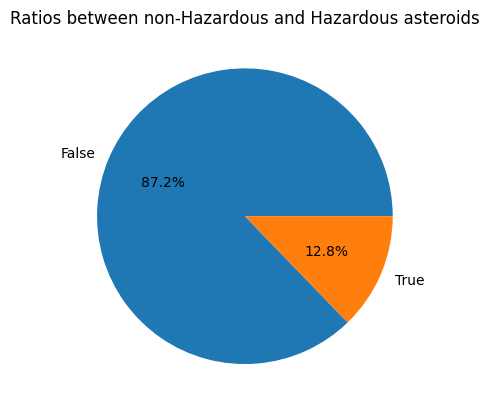

In [14]:
is_h = df.is_hazardous

plt.pie(x=is_h.value_counts(), labels=is_h.value_counts().index, autopct='%1.1f%%')
plt.title("Ratios between non-Hazardous and Hazardous asteroids")
plt.show()

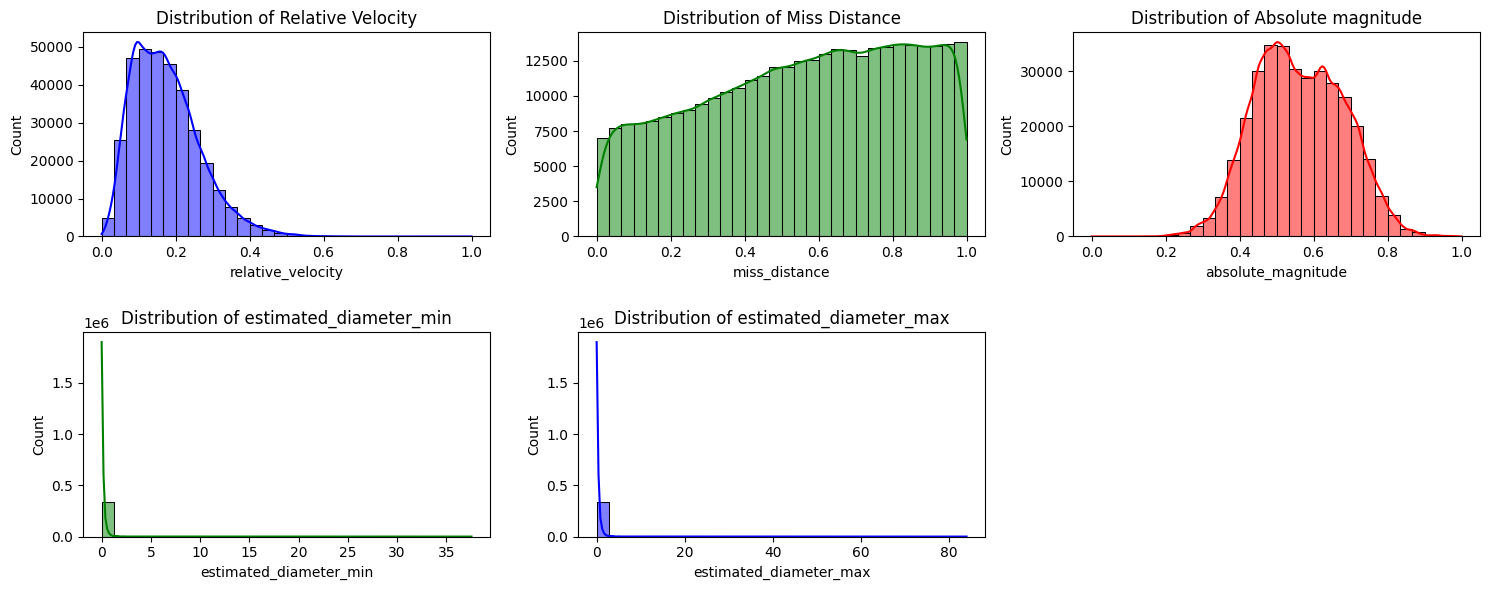

In [15]:
plt.figure(figsize=(15, 6))

# Distribution of relative velocity
plt.subplot(2, 3, 1)
sns.histplot(df['relative_velocity'], kde=True, bins=30, color='blue')
plt.title('Distribution of Relative Velocity')

# Distribution of miss distance
plt.subplot(2, 3, 2)
sns.histplot(df['miss_distance'], kde=True, bins=30, color='green')
plt.title('Distribution of Miss Distance')

# Distribution of absolute magnitude
plt.subplot(2, 3, 3)
sns.histplot(df['absolute_magnitude'], kde=True, bins=30, color='red')
plt.title('Distribution of Absolute magnitude')

plt.subplot(2, 3, 4)
sns.histplot(df['estimated_diameter_min'], kde=True, bins=30, color='green')
plt.title('Distribution of estimated_diameter_min')

plt.subplot(2, 3, 5)
sns.histplot(df['estimated_diameter_max'], kde=True, bins=30, color='blue')
plt.title('Distribution of estimated_diameter_max')
plt.tight_layout()
plt.show()

Handling imbalanced dataset  

In [16]:
X = df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']]
y = df['is_hazardous'].astype(int) #FALSE - 0, TRUE - 1
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
print("Class distribution before SMOTE:")
print(y_train.value_counts())
print("\nClass distribution after SMOTE:")
print(pd.Series(y_train_balanced).value_counts())

Class distribution before SMOTE:
is_hazardous
0    236039
1     34516
Name: count, dtype: int64

Class distribution after SMOTE:
is_hazardous
0    236039
1    118019
Name: count, dtype: int64


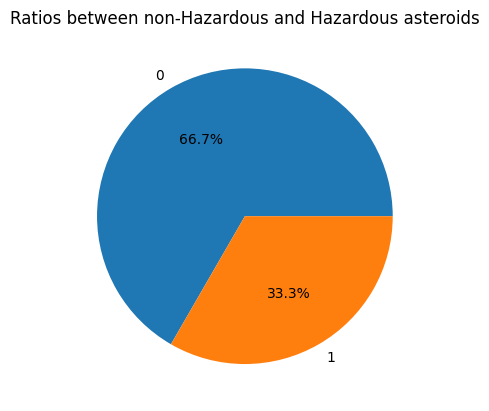

In [17]:
plt.pie(x=y_train_balanced.value_counts(), labels=y_train_balanced.value_counts().index, autopct='%1.1f%%')
plt.title("Ratios between non-Hazardous and Hazardous asteroids")
plt.show()

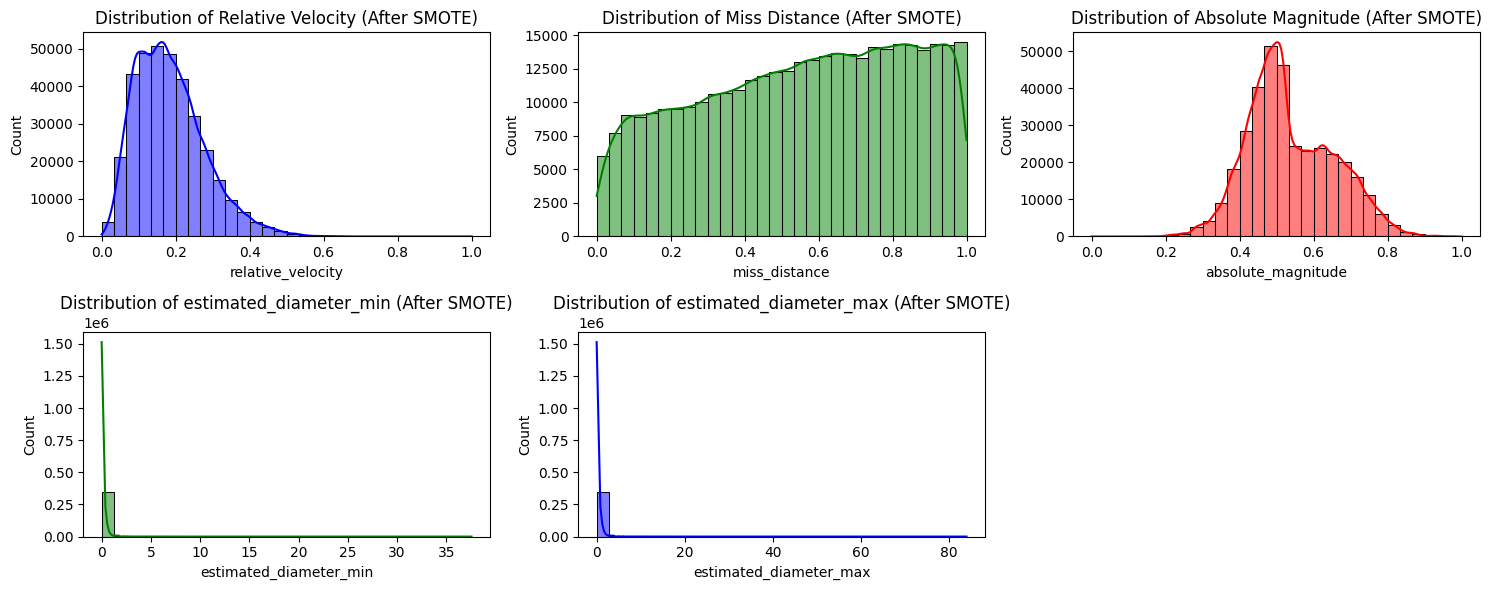

In [18]:
X_train_balanced_df = pd.DataFrame(X_train_balanced, columns=['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance'])
y_train_balanced_df = pd.DataFrame(y_train_balanced, columns=['is_hazardous'])
plt.figure(figsize=(15, 6))

# Distribution of relative velocity after SMOTE
plt.subplot(2, 3, 1)
sns.histplot(X_train_balanced_df['relative_velocity'], kde=True, bins=30, color='blue')
plt.title('Distribution of Relative Velocity (After SMOTE)')

# Distribution of miss distance after SMote
plt.subplot(2, 3, 2)
sns.histplot(X_train_balanced_df['miss_distance'], kde=True, bins=30, color='green')
plt.title('Distribution of Miss Distance (After SMOTE)')

# Distribution of absolute magnitude after SMOTE
plt.subplot(2, 3, 3)
sns.histplot(X_train_balanced_df['absolute_magnitude'], kde=True, bins=30, color='red')
plt.title('Distribution of Absolute Magnitude (After SMOTE)')

plt.subplot(2, 3, 4)
sns.histplot(X_train_balanced_df['estimated_diameter_min'], kde=True, bins=30, color='green')
plt.title('Distribution of estimated_diameter_min (After SMOTE)')

plt.subplot(2, 3, 5)
sns.histplot(X_train_balanced_df['estimated_diameter_max'], kde=True, bins=30, color='blue')
plt.title('Distribution of estimated_diameter_max (After SMOTE)')

plt.tight_layout()
plt.show()

#Train

In [19]:
X = df[['absolute_magnitude', 'estimated_diameter_min', 'estimated_diameter_max', 'relative_velocity', 'miss_distance']]
y = df['is_hazardous'].astype(int)  # FALSE - 0, TRUE - 1

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)  # 0.25 x 0.8 = 0.2

smote = SMOTE(random_state=42, sampling_strategy=0.5)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)

KNN


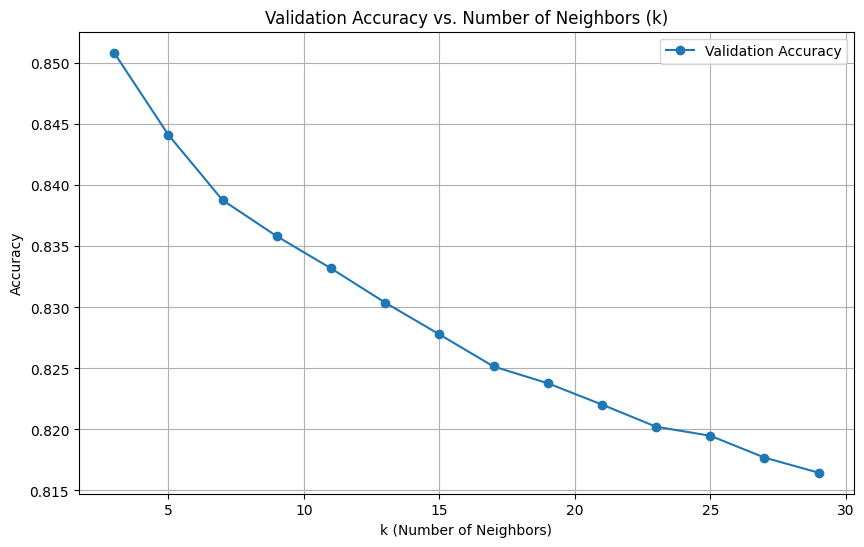

In [26]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import joblib

k_values = range(3, 30, 2)
validation_accuracies = []

with joblib.parallel_backend('loky'):
    for k in k_values:
        clf = KNeighborsClassifier(n_neighbors=k, n_jobs=-1)
        clf.fit(X_train_balanced, y_train_balanced)

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(k_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('k (Number of Neighbors)')
plt.ylabel('Accuracy')
plt.title('Validation Accuracy vs. Number of Neighbors (k)')
plt.grid(True)

plt.legend()
plt.show()

In [ ]:
param_grid = {
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'cosine']
}

results = []

for weight in param_grid['weights']:
    for metric in param_grid['metric']:
        with joblib.parallel_backend('loky'):
            clf = KNeighborsClassifier(n_neighbors=3, weights=weight, metric=metric, n_jobs=-1)

            clf.fit(X_train_balanced, y_train_balanced)

            y_val_pred = clf.predict(X_val)
            accuracy = accuracy_score(y_val, y_val_pred)

            results.append({
                'weights': weight,
                'distance_metric': metric,
                'accuracy': accuracy
            })

results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by='accuracy', ascending=False)
results_df.reset_index(drop=True, inplace=True)

display(results_df)

,weights,distance_metric,accuracy
0,uniform,manhattan,0.869439
1,distance,manhattan,0.869439
2,uniform,euclidean,0.861855
3,distance,euclidean,0.861855
4,uniform,cosine,0.859090
5,distance,cosine,0.859090


Naive Bayes


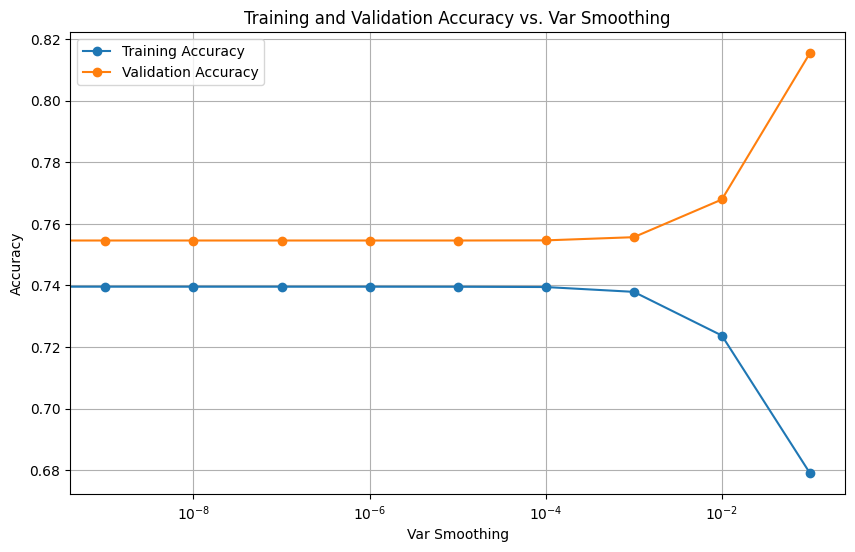

In [48]:
var_smoothing_values = [0, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1]

train_accuracies = []
validation_accuracies = []

for var_smoothing in var_smoothing_values:
    # Khởi tạo GaussianNB với var_smoothing
    clf = GaussianNB(var_smoothing=var_smoothing)
    clf.fit(X_train_balanced, y_train_balanced)

    # Đo lường độ chính xác trên tập huấn luyện
    y_train_pred = clf.predict(X_train_balanced)
    train_accuracies.append(accuracy_score(y_train_balanced, y_train_pred))

    # Đo lường độ chính xác trên tập kiểm tra
    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
plt.semilogx(var_smoothing_values, train_accuracies, marker='o', label='Training Accuracy')
plt.semilogx(var_smoothing_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Var Smoothing')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Var Smoothing')
plt.grid(True)
plt.legend()
plt.show()

Decision Tree

Chọn 9 vì cân bằng tốt nhất giữa độ phức tạp của mô hình và khả năng khái quát hóa, khi tăng độ sâu mô hình trở nên phức tạp hơn nhưng tập val vẫn chạy ngang (overfitting)

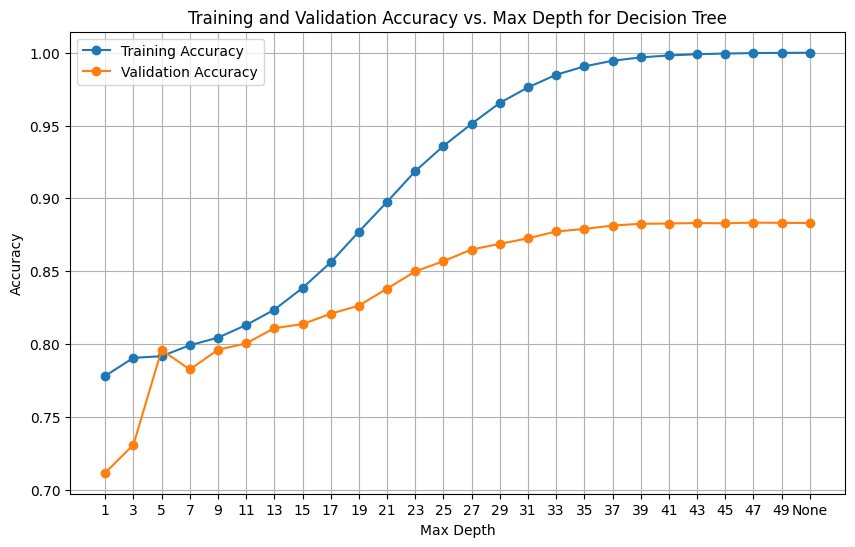

In [29]:
max_depth_values = [i for i in range(1,50,2)]
max_depth_values.append(None)
train_accuracies = []
validation_accuracies = []

for max_depth in max_depth_values:
    clf = DecisionTreeClassifier(max_depth=max_depth)
    clf.fit(X_train_balanced, y_train_balanced)

    # Dự đoán trên tập huấn luyện
    y_train_pred = clf.predict(X_train_balanced)
    train_accuracies.append(accuracy_score(y_train_balanced, y_train_pred))

    # Dự đoán trên tập validation
    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

# Vẽ biểu đồ Accuracy theo max_depth
plt.figure(figsize=(10, 6))
plt.plot([str(md) for md in max_depth_values], train_accuracies, marker='o', label='Training Accuracy')
plt.plot([str(md) for md in max_depth_values], validation_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('Max Depth')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Depth for Decision Tree')
plt.grid(True)
plt.legend()
plt.show()

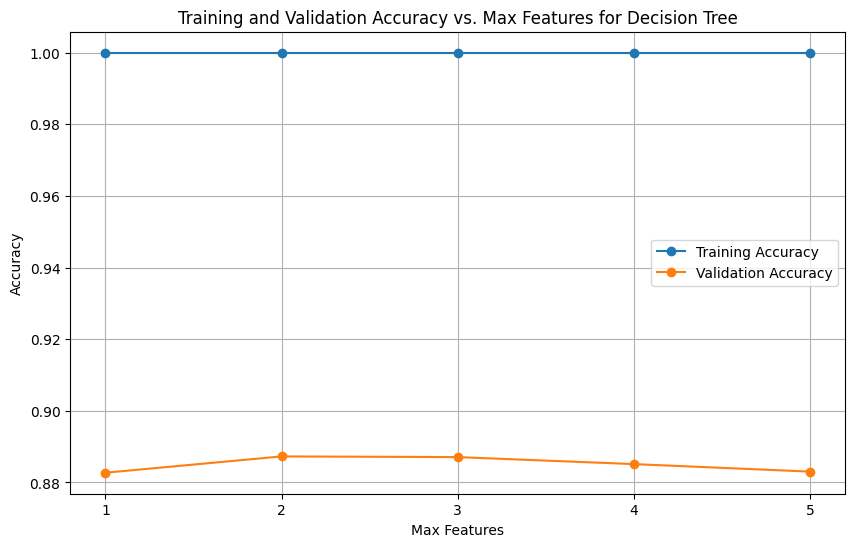

In [25]:
max_features_values = range(1, 6, 1)
train_accuracies = []
validation_accuracies = []

for max_features in max_features_values:
    clf = DecisionTreeClassifier(max_features=max_features)
    clf.fit(X_train_balanced, y_train_balanced)

    # Dự đoán trên tập huấn luyện
    y_train_pred = clf.predict(X_train_balanced)
    train_accuracies.append(accuracy_score(y_train_balanced, y_train_pred))

    # Dự đoán trên tập validation
    y_val_pred = clf.predict(X_val)
    validation_accuracies.append(accuracy_score(y_val, y_val_pred))

# Vẽ biểu đồ Accuracy theo max_features
plt.figure(figsize=(10, 6))
plt.plot([str(mf) for mf in max_features_values], train_accuracies, marker='o', label='Training Accuracy')
plt.plot([str(mf) for mf in max_features_values], validation_accuracies, marker='o', label='Validation Accuracy')

plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Features for Decision Tree')
plt.grid(True)
plt.legend()
plt.show()

min_samples_split_values 5, entropy

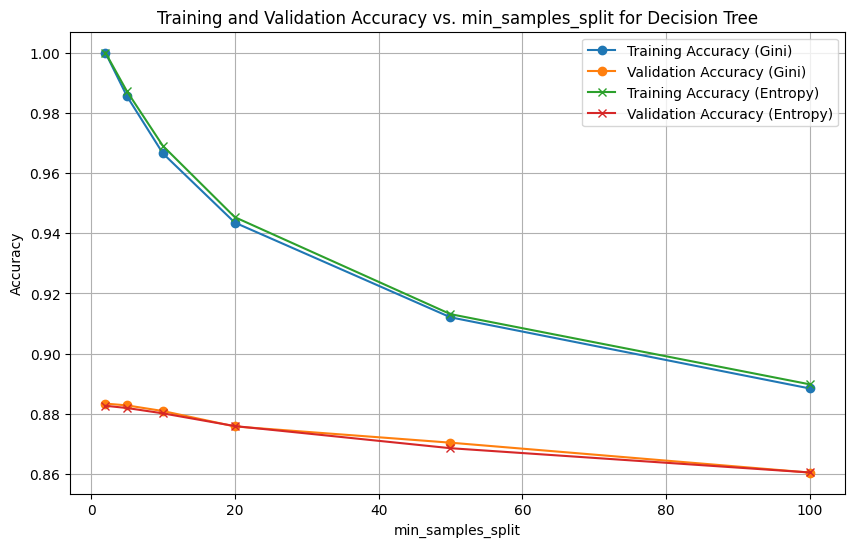

In [53]:
min_samples_split_values = [2, 5, 10, 20, 50, 100]
train_accuracies_gini = []
validation_accuracies_gini = []
train_accuracies_entropy = []
validation_accuracies_entropy = []

for min_samples_split in min_samples_split_values:
    clf_gini = DecisionTreeClassifier(min_samples_split=min_samples_split, criterion='gini')
    clf_gini.fit(X_train_balanced, y_train_balanced)
    y_train_pred_gini = clf_gini.predict(X_train_balanced)
    train_accuracies_gini.append(accuracy_score(y_train_balanced, y_train_pred_gini))
    y_val_pred_gini = clf_gini.predict(X_val)
    validation_accuracies_gini.append(accuracy_score(y_val, y_val_pred_gini))
    clf_entropy = DecisionTreeClassifier(min_samples_split=min_samples_split, criterion='entropy')
    clf_entropy.fit(X_train_balanced, y_train_balanced)
    y_train_pred_entropy = clf_entropy.predict(X_train_balanced)
    train_accuracies_entropy.append(accuracy_score(y_train_balanced, y_train_pred_entropy))
    y_val_pred_entropy = clf_entropy.predict(X_val)
    validation_accuracies_entropy.append(accuracy_score(y_val, y_val_pred_entropy))
plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_accuracies_gini, marker='o', label='Training Accuracy (Gini)')
plt.plot(min_samples_split_values, validation_accuracies_gini, marker='o', label='Validation Accuracy (Gini)')
plt.plot(min_samples_split_values, train_accuracies_entropy, marker='x', label='Training Accuracy (Entropy)')
plt.plot(min_samples_split_values, validation_accuracies_entropy, marker='x', label='Validation Accuracy (Entropy)')
plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. min_samples_split for Decision Tree')
plt.grid(True)
plt.legend()
plt.show()

Random Forest

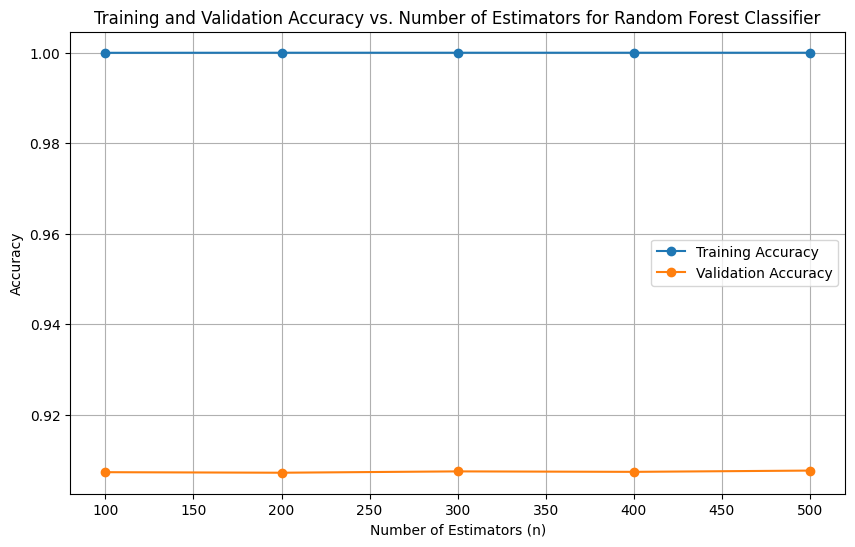

In [ ]:
n_values = range(100, 501, 100)
train_accuracies = []
validation_accuracies = []

for n in n_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=n, n_jobs=-1)
        clf.fit(X_train_balanced, y_train_balanced)

        y_train_pred = clf.predict(X_train_balanced)
        train_accuracies.append(accuracy_score(y_train_balanced, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(n_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(n_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Number of Estimators (n)')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Estimators for Random Forest Classifier')
plt.grid(True)
plt.legend()
plt.show()

Random Forest

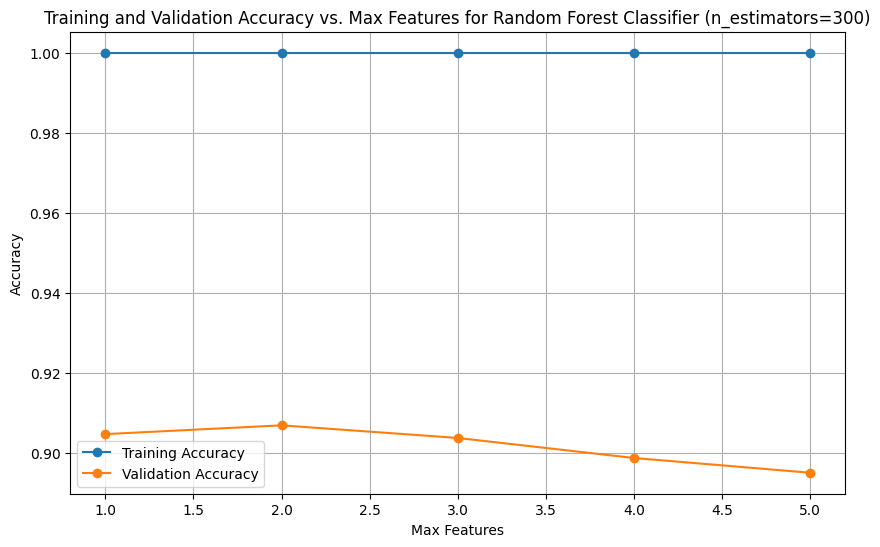

In [ ]:
max_features_values = range(1, 6, 1)
train_accuracies = []
validation_accuracies = []

for max_features in max_features_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=max_features, n_jobs=-1)
        clf.fit(X_train_balanced, y_train_balanced)

        y_train_pred = clf.predict(X_train_balanced)
        train_accuracies.append(accuracy_score(y_train_balanced, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(max_features_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(max_features_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Max Features')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Max Features for Random Forest Classifier (n_estimators=300)')
plt.grid(True)
plt.legend()
plt.show()

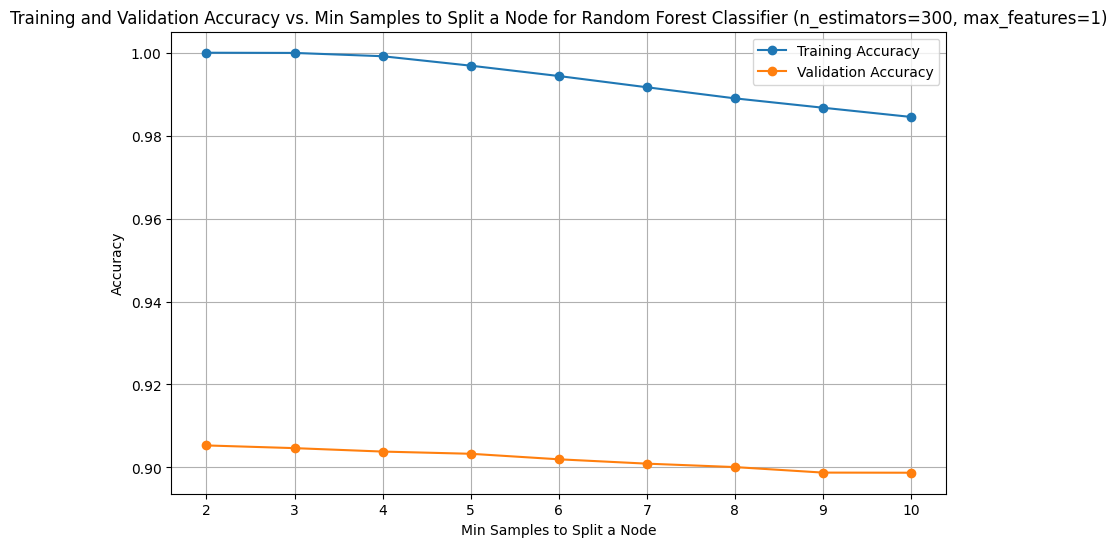

In [ ]:
min_samples_split_values = range(2, 11, 1)
train_accuracies = []
validation_accuracies = []

for min_samples_split in min_samples_split_values:
    with joblib.parallel_backend('loky'):
        clf = RandomForestClassifier(n_estimators=300, max_features=1, min_samples_split=min_samples_split, n_jobs=-1)
        clf.fit(X_train_balanced, y_train_balanced)

        y_train_pred = clf.predict(X_train_balanced)
        train_accuracies.append(accuracy_score(y_train_balanced, y_train_pred))

        y_val_pred = clf.predict(X_val)
        validation_accuracies.append(accuracy_score(y_val, y_val_pred))

plt.figure(figsize=(10, 6))
plt.plot(min_samples_split_values, train_accuracies, marker='o', label='Training Accuracy')
plt.plot(min_samples_split_values, validation_accuracies, marker='o', label='Validation Accuracy')
plt.xlabel('Min Samples to Split a Node')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Min Samples to Split a Node for Random Forest Classifier (n_estimators=300, max_features=1)')
plt.grid(True)
plt.legend()
plt.show()

Hold out

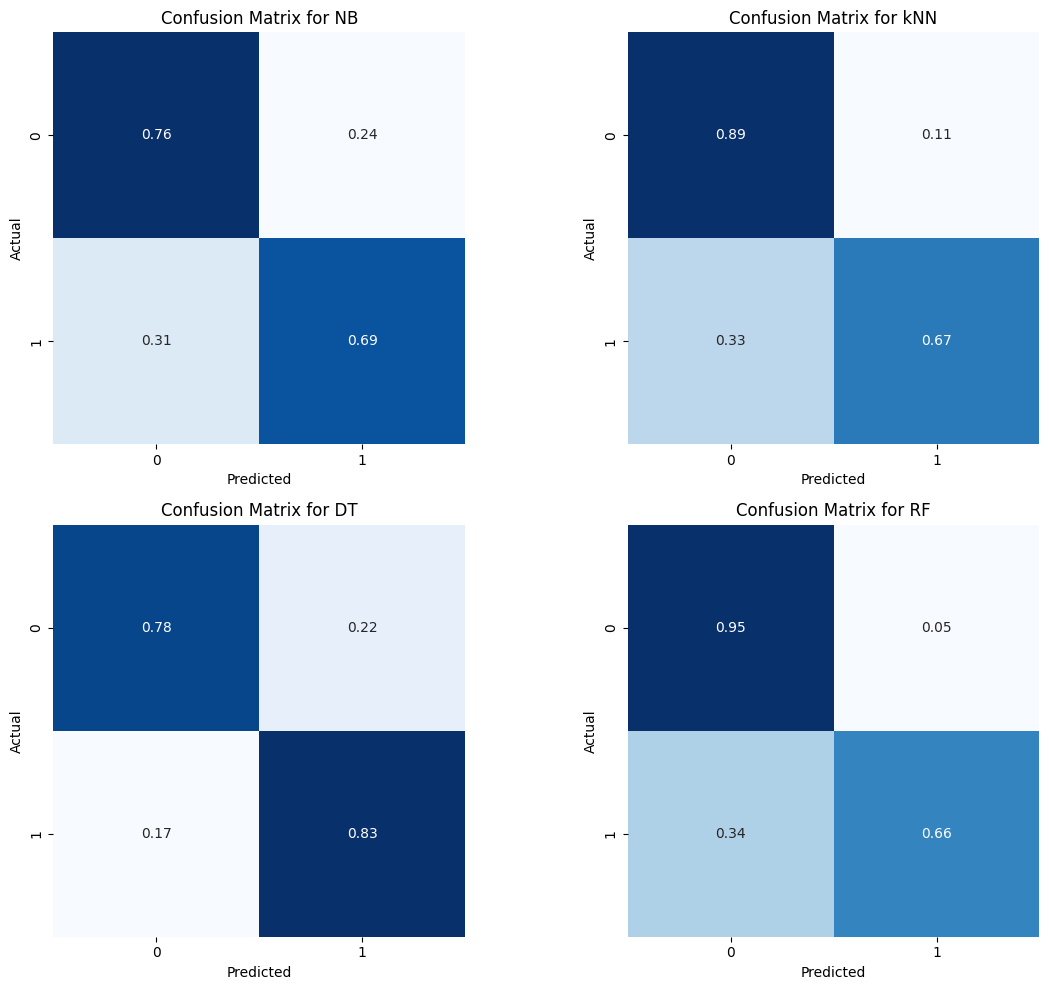

,Accuracy,Precision,Recall,F1 Score,Training Time (s),Testing Time (ms)
NB,75.34%,0.8615,0.7534,0.7891,0.07,10.27
kNN,86.24%,0.8878,0.8624,0.8721,0.88,4833.55
DT,78.38%,0.8905,0.7838,0.8156,0.98,7.86
RF,91.02%,0.9110,0.9102,0.9106,185.31,2090.67


In [65]:
clf0 = GaussianNB()
clf1 = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='manhattan', n_jobs=-1)
clf2 = DecisionTreeClassifier(max_depth=9, max_features=2, min_samples_split=5,criterion='entropy')
clf3 = RandomForestClassifier(n_estimators=300, max_features=2, min_samples_split=3, n_jobs=-1)

classifiers = [clf0, clf1, clf2, clf3]
classifier_labels = ['NB', 'kNN', 'DT', 'RF']

training_times = []
testing_times = []
accuracies = []
confusion_matrices = []
precisions = []
recalls = []
f1_scores = []

for i, clf in enumerate(classifiers):
    with parallel_backend('loky'):
        start_time1 = time.time()
        clf.fit(X_train_balanced, y_train_balanced)
        end_time1 = time.time()
        training_time = end_time1 - start_time1
        training_times.append(training_time)

        start_time2 = time.time()
        y_pred = clf.predict(X_test)
        end_time2 = time.time()
        testing_time = (end_time2 - start_time2) * 1000  # Convert to milliseconds
        testing_times.append(testing_time)

        accuracy = accuracy_score(y_test, y_pred)
        accuracies.append(accuracy)

        confusion = confusion_matrix(y_test, y_pred, normalize='true')
        confusion_matrices.append(confusion)

        precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='weighted')
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1)

plt.figure(figsize=(12, 10))

for i, clf_label in enumerate(classifier_labels):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(confusion_matrices[i], annot=True, fmt='.2f', cbar=False, cmap='Blues', xticklabels=clf.classes_, yticklabels=clf.classes_, square=True)
    plt.title(f'Confusion Matrix for {clf_label}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

plt.tight_layout()
plt.show()

test_results = {
    # 'Parameters': [str(clf.get_params()) for clf in classifiers],
    'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
    'Precision': [f'{prec:.4f}' for prec in precisions],
    'Recall': [f'{rec:.4f}' for rec in recalls],
    'F1 Score': [f'{f1:.4f}' for f1 in f1_scores],
    'Training Time (s)': [f'{time:.2f}' for time in training_times],
    'Testing Time (ms)': [f'{time:.2f}' for time in testing_times]
}

display(pd.DataFrame(test_results, index=classifier_labels))

Kfold


Evaluating NB:
K-Fold Cross-Validation Results:
Accuracy: 0.7309 (+/- 0.0097)
Precision: 0.5867 (+/- 0.0113)
Recall: 0.6586 (+/- 0.0346)
F1-score: 0.6206 (+/- 0.0207)

Evaluating kNN:
K-Fold Cross-Validation Results:
Accuracy: 0.8934 (+/- 0.0020)
Precision: 0.7889 (+/- 0.0077)
Recall: 0.9193 (+/- 0.0047)
F1-score: 0.8513 (+/- 0.0032)

Evaluating DT:
K-Fold Cross-Validation Results:
Accuracy: 0.7978 (+/- 0.0034)
Precision: 0.6433 (+/- 0.0164)
Recall: 0.8121 (+/- 0.0675)
F1-score: 0.7318 (+/- 0.0163)

Evaluating RF:
K-Fold Cross-Validation Results:
Accuracy: 0.9275 (+/- 0.0011)
Precision: 0.8819 (+/- 0.0041)
Recall: 0.9003 (+/- 0.0035)
F1-score: 0.8921 (+/- 0.0019)


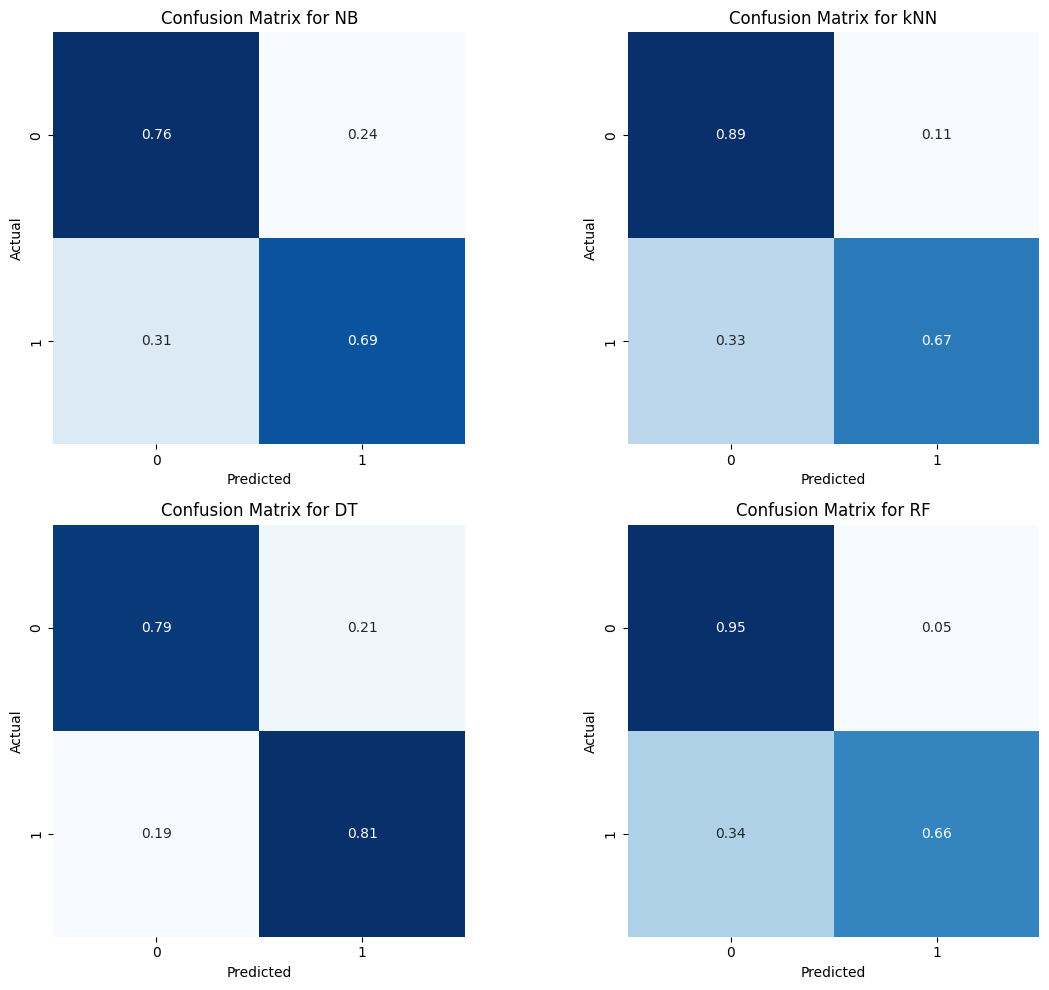

,Model,Accuracy,Precision,Recall,F1 Score,Training Time (s),Testing Time (ms)
0,NB,75.34%,0.8615,0.7534,0.7891,1.61,126.77
1,kNN,86.24%,0.8878,0.8624,0.8721,18.11,3531.05
2,DT,79.16%,0.8890,0.7916,0.8212,2.46,1046.02
3,RF,90.98%,0.9106,0.9098,0.9102,708.18,170301.84


In [67]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, make_scorer
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import time

# Define models to evaluate
models = {
    "NB": GaussianNB(),
    "kNN": KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='manhattan', n_jobs=-1),
    "DT": DecisionTreeClassifier(max_depth=9, max_features=2, min_samples_split=5,criterion='entropy'),
    "RF": RandomForestClassifier(n_estimators=300, max_features=2, min_samples_split=3, n_jobs=-1),
}

# Lists to store evaluation metrics
training_times = []
testing_times = []
accuracies = []
confusion_matrices = []
precisions = []
recalls = []
f1_scores = []

# Evaluation method (KFold Cross-validation and Hold-out testing)
def evaluate_model_with_metrics(model, X_train_balanced, y_train_balanced, X_test, y_test):
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    scoring = {
        'accuracy': 'accuracy',
        'precision': make_scorer(precision_score),
        'recall': make_scorer(recall_score),
        'f1': make_scorer(f1_score)
    }

    # Perform cross-validation
    start_time1 = time.time()
    cv_results = cross_validate(model, X_train_balanced, y_train_balanced, cv=kf, scoring=scoring)
    end_time1 = time.time()
    training_time = end_time1 - start_time1
    training_times.append(training_time)

    # Fit model on the training data
    start_time2 = time.time()
    model.fit(X_train_balanced, y_train_balanced)
    y_pred = model.predict(X_test)
    end_time2 = time.time()
    testing_time = (end_time2 - start_time2) * 1000  # Convert to milliseconds
    testing_times.append(testing_time)

    # Metrics on the test set
    accuracy = accuracy_score(y_test, y_pred)
    accuracies.append(accuracy)

    precision = precision_score(y_test, y_pred, average='weighted')
    precisions.append(precision)

    recall = recall_score(y_test, y_pred, average='weighted')
    recalls.append(recall)

    f1 = f1_score(y_test, y_pred, average='weighted')
    f1_scores.append(f1)

    confusion = confusion_matrix(y_test, y_pred, normalize='true')
    confusion_matrices.append(confusion)

    # Print Cross-Validation results
    print("K-Fold Cross-Validation Results:")
    print(f"Accuracy: {min(cv_results['test_accuracy']):.4f} (+/- {cv_results['test_accuracy'].std() * 2:.4f})")
    print(f"Precision: {min(cv_results['test_precision']):.4f} (+/- {cv_results['test_precision'].std() * 2:.4f})")
    print(f"Recall: {min(cv_results['test_recall']):.4f} (+/- {cv_results['test_recall'].std() * 2:.4f})")
    print(f"F1-score: {min(cv_results['test_f1']):.4f} (+/- {cv_results['test_f1'].std() * 2:.4f})")

# Loop through each model and evaluate
for model_name, model in models.items():
    print(f"\nEvaluating {model_name}:")
    evaluate_model_with_metrics(model, X_train_balanced, y_train_balanced, X_test, y_test)

# Plot Confusion Matrices
plt.figure(figsize=(12, 10))
for i, (model_name, confusion_matrix) in enumerate(zip(models.keys(), confusion_matrices)):
    plt.subplot(2, 2, i + 1)
    sns.heatmap(confusion_matrix, annot=True, fmt='.2f', cbar=False, cmap='Blues', square=True)
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
plt.tight_layout()
plt.show()

# Display final test results in a DataFrame
test_results = {
    'Model': list(models.keys()),
    'Accuracy': [f'{acc * 100:.2f}%' for acc in accuracies],
    'Precision': [f'{prec:.4f}' for prec in precisions],
    'Recall': [f'{rec:.4f}' for rec in recalls],
    'F1 Score': [f'{f1:.4f}' for f1 in f1_scores],
    'Training Time (s)': [f'{time:.2f}' for time in training_times],
    'Testing Time (ms)': [f'{time:.2f}' for time in testing_times]
}

# Display results as a DataFrame
results_df = pd.DataFrame(test_results)
display(results_df)


In [ ]:
import pickle

clf0 = GaussianNB()
clf1 = KNeighborsClassifier(n_neighbors=3, weights='uniform', metric='manhattan', n_jobs=2)
clf2 = DecisionTreeClassifier(max_depth=9, max_features=2, min_samples_split=5,criterion='entropy')
clf3 = RandomForestClassifier(n_estimators=300, max_features=2, min_samples_split=3, n_jobs=2)

classifiers = [clf0, clf1, clf2, clf3]
classifier_labels = ['NB', 'kNN', 'DT', 'RF']

for i, clf in enumerate(classifiers):
    clf.fit(X_train_balanced, y_train_balanced)
    with open(f"{classifier_labels[i]}.pkl", "wb") as file:
        pickle.dump(model, file)











